In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import math
import seaborn as sns


In [2]:
#Reading data
#Spanish data from spanish health ministry, all hisotrical series
data = pd.read_csv(r"https://covid19.isciii.es/resources/serie_historica_acumulados.csv",skipfooter=3,error_bad_lines=False,encoding = 'ANSI')

data.columns = ['CCAA Codigo ISO','Fecha','Casos','Hospitalizados','UCI','Fallecidos','Recuperados']
#World data from Johns Hopkins University (github)
#Confirmed cases
data_jh_conf = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed deaths
data_jh_muertos = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed recovered
data_jh_recuperados = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Cataluña data
data_cat = pd.read_csv(r"https://analisi.transparenciacatalunya.cat/api/views/jj6z-iyrp/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B&sorting=true", sep=";",encoding = 'utf-8')

#Spanish data from Madrid
data_madrid = pd.read_csv(r"https://datos.comunidad.madrid/catalogo/dataset/7da43feb-8d4d-47e0-abd5-3d022d29d09e/resource/b2a3a3f9-1f82-42c2-89c7-cbd3ef801412/download/covid19_tia_muni_y_distritos.csv", sep=";",encoding = 'ANSI')

#datos de renta por municipios
data_renta_municipios = pd.read_csv(r"C:\Users\guillermo.arguello\Documents\Covid Analisys\renta_municipios.csv", sep="|",encoding = 'ANSI')

#datos población paises

data_poblacion = pd.read_excel('https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx',
                                    sheet_name="ESTIMATES",skiprows= 16)

data_poblacion = data_poblacion[["Region, subregion, country or area *","2020"]]

In [3]:
#Transpose Johns Hopkins Data

data_jh_conf = data_jh_conf.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Casos')
data_jh_muertos = data_jh_muertos.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Fallecidos')
data_jh_recuperados = data_jh_recuperados.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Recuperados')

#Join all data in one dataframe
data_jh = pd.merge(data_jh_conf, data_jh_muertos, left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

data_jh = pd.merge(data_jh, data_jh_recuperados, how= 'left',left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

#Removing Province/State, Lat and long data, we won´t use it (it could be usefull for geographical plots)

data_jh = data_jh.drop(["Province/State","Lat","Long"], axis=1)


In [4]:
data_jh = data_jh.groupby(['Fecha','Country/Region'], as_index=False).sum()
data_jh = data_jh.sort_values(by=['Fecha'])
data_jh["Fecha2"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y").dt.strftime('%Y%m%d').astype(int).sort_values(ascending=False)
data_jh["Fecha"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y")

data_jh = data_jh.set_index('Fecha2')
data_jh = data_jh.sort_index()
data_jh = data_jh.reset_index()

data_jh['Diferencia casos dia anterior'] = data_jh.groupby('Country/Region', as_index=False).diff(1)["Casos"]
data_jh['Diferencia fallecidos dia anterior'] = data_jh.groupby('Country/Region', as_index=False).diff(1)["Fallecidos"]
data_jh['Diferencia recuperados dia anterior'] = data_jh.groupby('Country/Region', as_index=False).diff(1)["Recuperados"]
data_jh = data_jh.fillna(0)
data_jh = data_jh.drop(["Fecha2"], axis=1)

data_jh = pd.merge(data_jh, data_poblacion, how= 'left',left_on=['Country/Region'], 
                   right_on = ['Region, subregion, country or area *'])

data_jh = data_jh.set_index('Fecha')
data_jh["Incremento porcentual de casos respecto al total"]= data_jh["Diferencia casos dia anterior"]/data_jh["Casos"]*100
data_jh["Incremento porcentual de fallecidos respecto al total"]= data_jh["Diferencia fallecidos dia anterior"]/data_jh["Fallecidos"]*100

data_jh = data_jh.rename(columns={"2020": "2020 Population"})

data_jh["Fallecidos por millón habitantes"]= data_jh["Fallecidos"]/(data_jh["2020 Population"]/1000)


data_sem_jh = data_jh.groupby(['Country/Region'], as_index=True).rolling(7, center=False).mean()

In [5]:
data = data.fillna(0)
data.drop(data[ data['Fecha'] == 0 ].index , inplace=True)
data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%Y").sort_values()
data['Diferencia casos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Casos"]
data['Diferencia hospitalizados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Hospitalizados"]
data['Diferencia UCI dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["UCI"]
data['Diferencia fallecidos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Fallecidos"]
data['Diferencia recuperados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Recuperados"]

data = data.fillna(0)
data_es = data.groupby('Fecha', as_index=False).sum()
data_es = data_es.set_index('Fecha')
data_es = data_es[data_es["Fallecidos"] > 10]
data_es["Incremento porcentual de casos respecto al total"]= (data_es["Diferencia casos dia anterior"]/data_es["Casos"]*100).round(3)
data_es["Incremento porcentual de fallecidos respecto al total"]= (data_es["Diferencia fallecidos dia anterior"]/data_es["Fallecidos"]*100).round(3)

data_sem = data_es.rolling(7, center=False).mean()


In [6]:
data_cat["Data"] = pd.to_datetime(data_cat["Data"], format="%d/%m/%Y").sort_values()
data_cat_gropued = data_cat.groupby('Data',as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued = data_cat_gropued[data_cat_gropued["Data"] > "2020-03-01"]
data_cat_gropued = data_cat_gropued.set_index('Data')
data_cat_gropued_resultado = data_cat.groupby(['Data',"ResultatCovidDescripcio"],as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued_resultado = data_cat_gropued_resultado[data_cat_gropued_resultado["Data"] > "2020-03-01"]
data_cat_gropued_resultado = data_cat_gropued_resultado.set_index('Data')

In [7]:
#Procasamiento datos Madrid
data_madrid = data_madrid[["municipio_distrito","fecha_informe","casos_confirmados_totales","tasa_incidencia_acumulada_total"]]
data_madrid = data_madrid.dropna()
data_madrid["municipio_distrito"]= data_madrid["municipio_distrito"].str.strip()
data_renta_municipios["MUNICIPIO"]= data_renta_municipios["MUNICIPIO"].str.strip()

data_renta_municipios = data_renta_municipios[["MUNICIPIO","RENTA DISPONIBLE MEDIA","NUMERO HABITANTES"]]
data_mad = pd.merge(data_madrid, data_renta_municipios, how= 'left',left_on=['municipio_distrito'], 
                   right_on = ['MUNICIPIO'])

data_mad["tasa_incidencia_acumulada_total"] = data_mad["tasa_incidencia_acumulada_total"].str.replace(",",".")
data_mad["tasa_incidencia_acumulada_total"] = pd.to_numeric(data_mad["tasa_incidencia_acumulada_total"])
data_mad["NUMERO HABITANTES"] = data_mad["NUMERO HABITANTES"].str.replace(".","")
data_mad["NUMERO HABITANTES"] = pd.to_numeric(data_mad["NUMERO HABITANTES"])


#data_mad = data_mad.dropna(subset = ["RENTA BRUTA MEDIA"])
#data_mad = data_mad.dropna()


data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85 , "Renta Categorical"] = 'Renta Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1), "Renta Categorical"] = 'Renta Media-Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25), "Renta Categorical"] = 'Renta Media-Media'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5), "Renta Categorical"] = 'Renta Media-Alta'

data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] > data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5, "Renta Categorical"] = 'Renta Alta'


data_mad = data_mad[data_mad["NUMERO HABITANTES"] > 1000] 
data_mad = data_mad[data_mad["casos_confirmados_totales"] > 20] 


In [8]:
data_es.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_es_historical_series.csv')
data_jh.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\john_hopkins_university_historical_series.csv')
data_cat_gropued.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_catalunya.csv')
data_mad.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_madrid.csv')


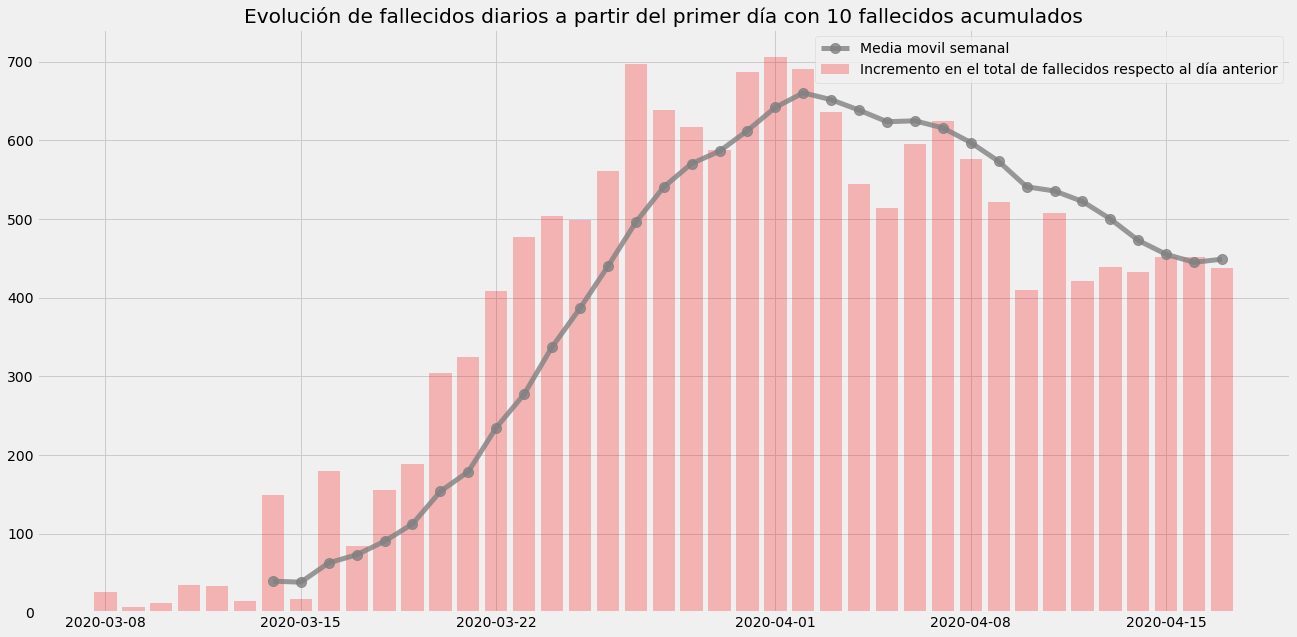

In [9]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia fallecidos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia fallecidos dia anterior"],width=0.8, alpha=0.25, color='red',
       label='Incremento en el total de fallecidos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de fallecidos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos.png');



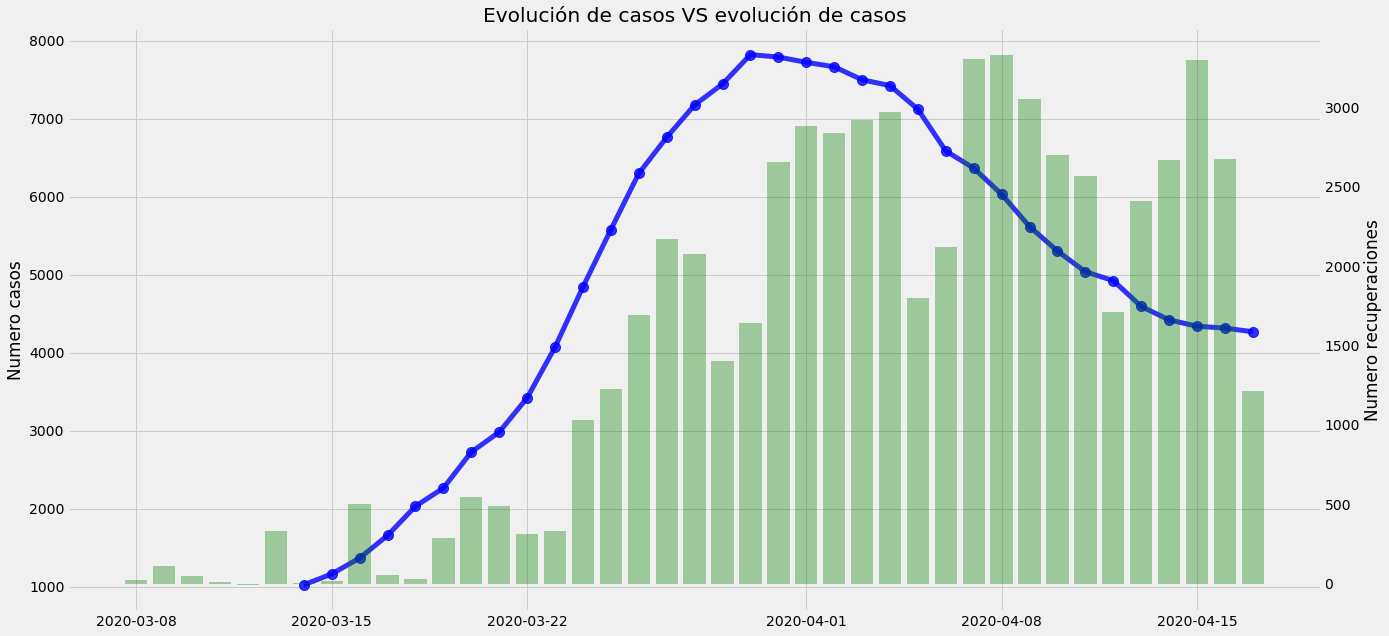

In [10]:
# Let's build our plot
# Set up plot 

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  # set up the 2nd axis

#Next lines plot the line of the plot

ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=0.8,color='blue',
         label='Incremento en el total de casos respecto al día anterior',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_sem.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.35, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')


ax2.grid(b=False) # turn off grid #2

ax1.set_title('Evolución de casos VS evolución de casos')
ax1.set_ylabel('Numero casos')
ax2.set_ylabel('Numero recuperaciones');



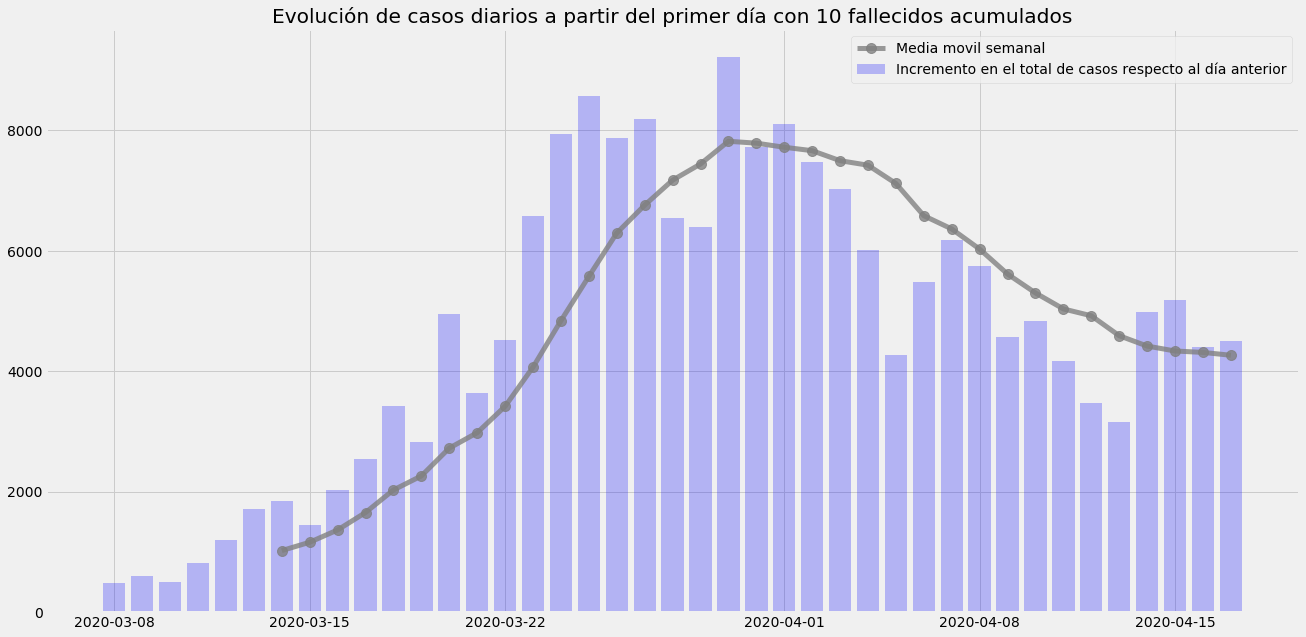

In [11]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia casos dia anterior"],width=0.8, alpha=0.25, color='blue',
       label='Incremento en el total de casos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos.png');




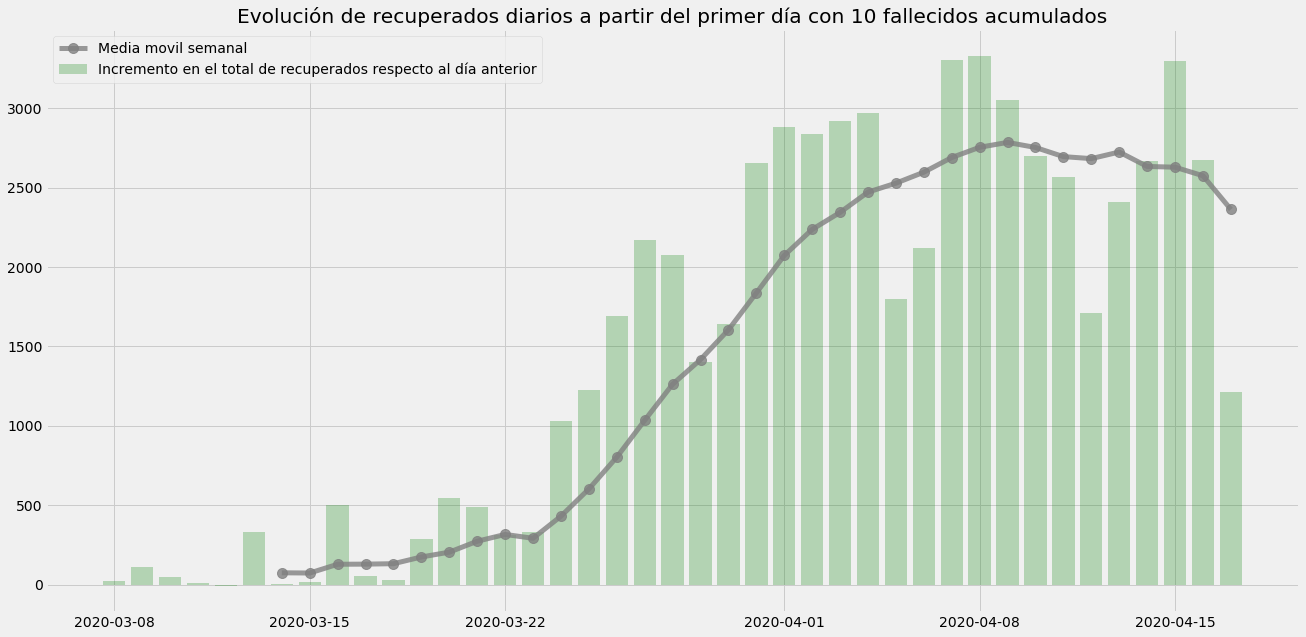

In [12]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia recuperados dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.25, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de recuperados diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\recuperados.png');


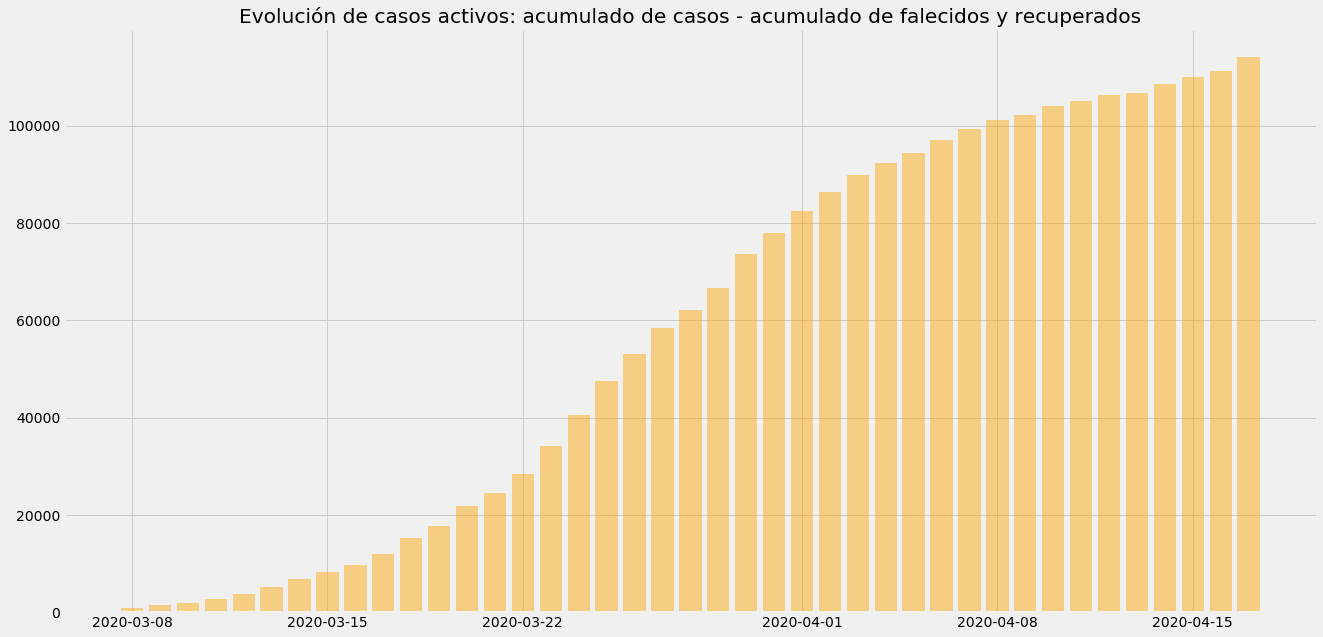

In [13]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Casos"] - data_es["Fallecidos"] - data_es["Recuperados"],
        width=0.8, alpha=0.45, color='orange')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos activos: acumulado de casos - acumulado de falecidos y recuperados')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_activos.png');


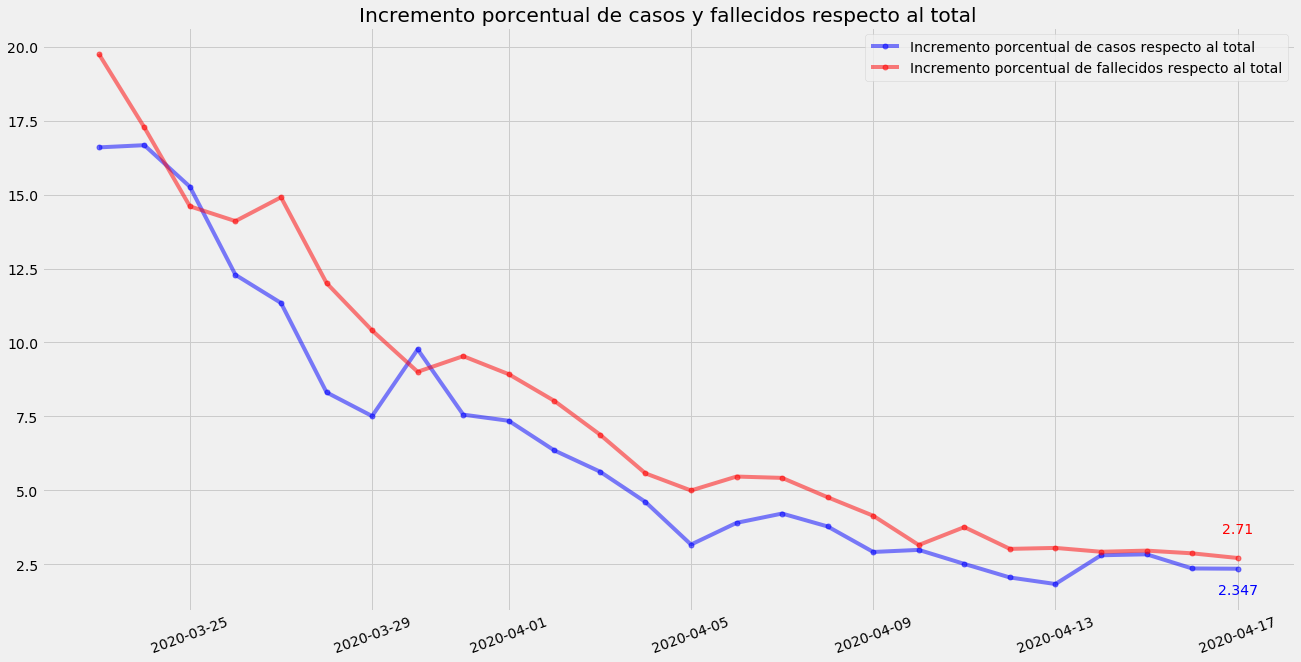

In [14]:
start, end = '2020-03-23 00:00:00', data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-',alpha=0.5,color='blue',
        label='Incremento porcentual de casos respecto al total')

ax.plot(data_es.loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, alpha=0.5,color='red',linestyle='-', label='Incremento porcentual de fallecidos respecto al total')

plt.xticks(rotation=20)
plt.title("Incremento porcentual de casos y fallecidos respecto al total")

plt.annotate(data_es.loc[end, 'Incremento porcentual de casos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de casos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center',color='blue') # horizontal alignment can be left, right or center
plt.annotate(data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,25), # distance from text to points (x,y)
                 ha='center',color='red') # horizontal alignment can be left, right or center

ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\incremento_porcentual.png');


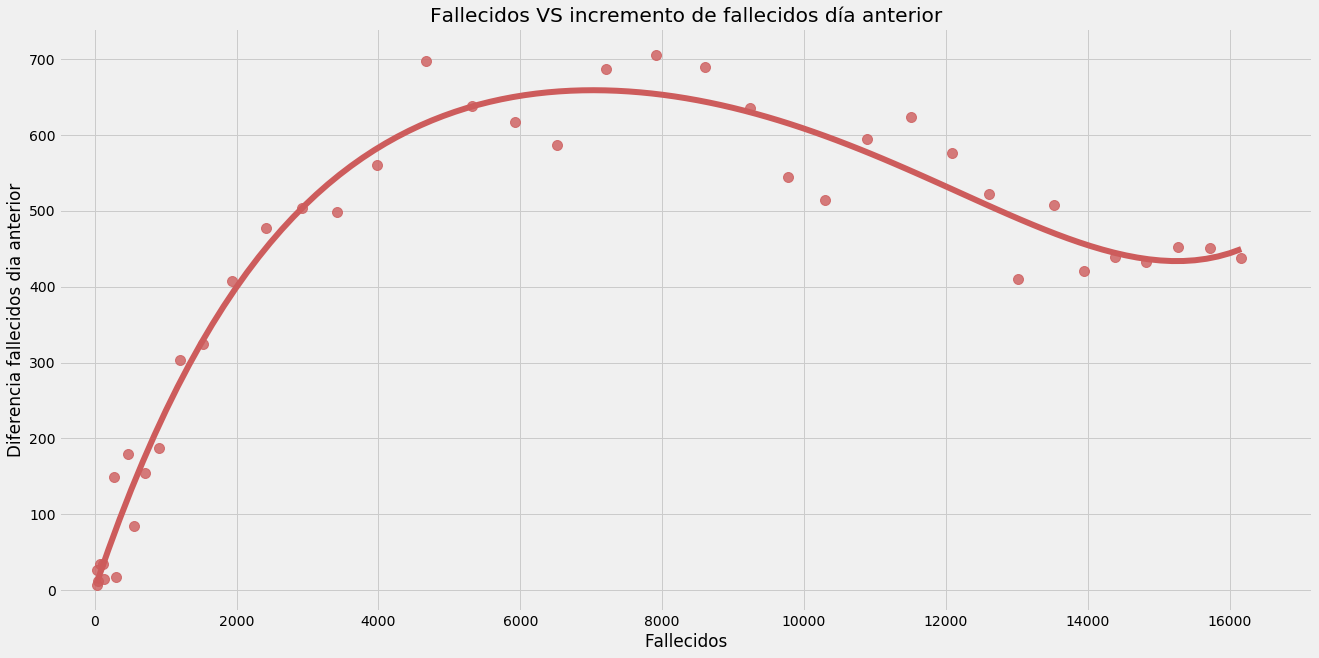

In [15]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Fallecidos']
Y = data_es.loc[start:end, 'Diferencia fallecidos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 100},order=5, ci=False,color='indianred')
plt.title("Fallecidos VS incremento de fallecidos día anterior")
ax.set(xlim=(-500, data_es["Fallecidos"].max() + 1000))
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos_VS_incremento.png');



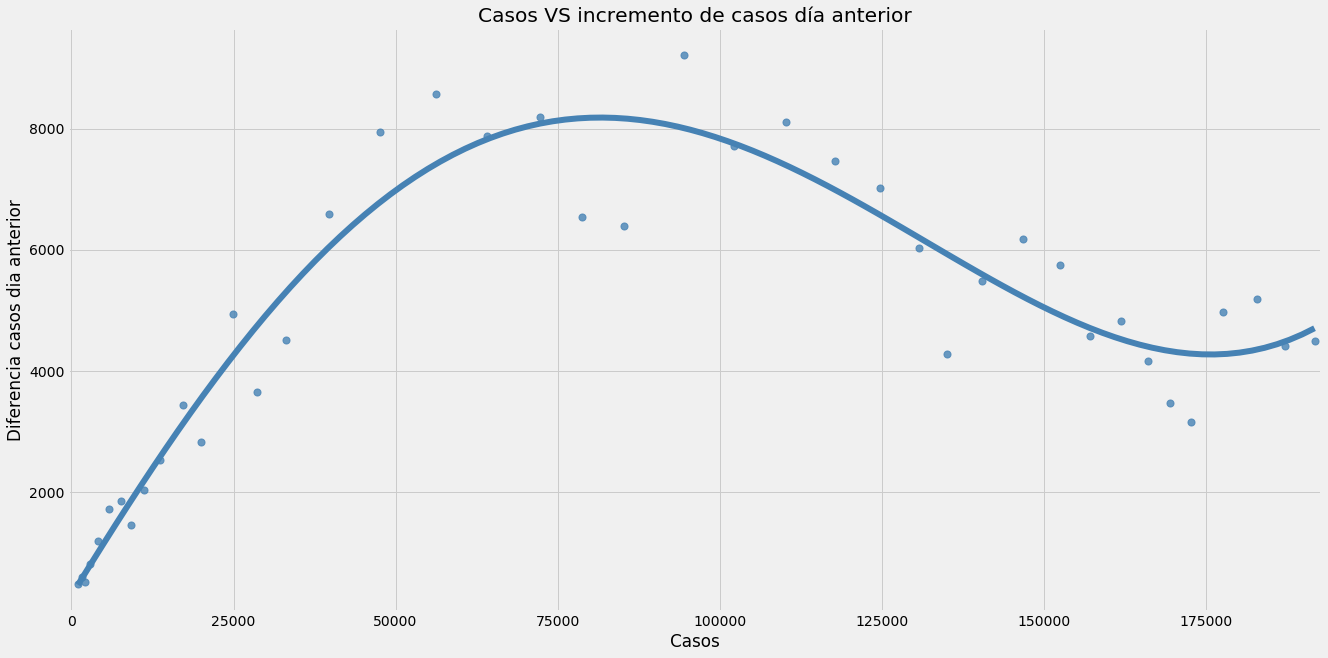

In [16]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Casos']
Y = data_es.loc[start:end, 'Diferencia casos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 50},order=5, ci=True,color='steelblue')
ax.set(xlim=(-500, data_es["Casos"].max() + 1000))

plt.title("Casos VS incremento de casos día anterior")
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_VS_incremento.png');



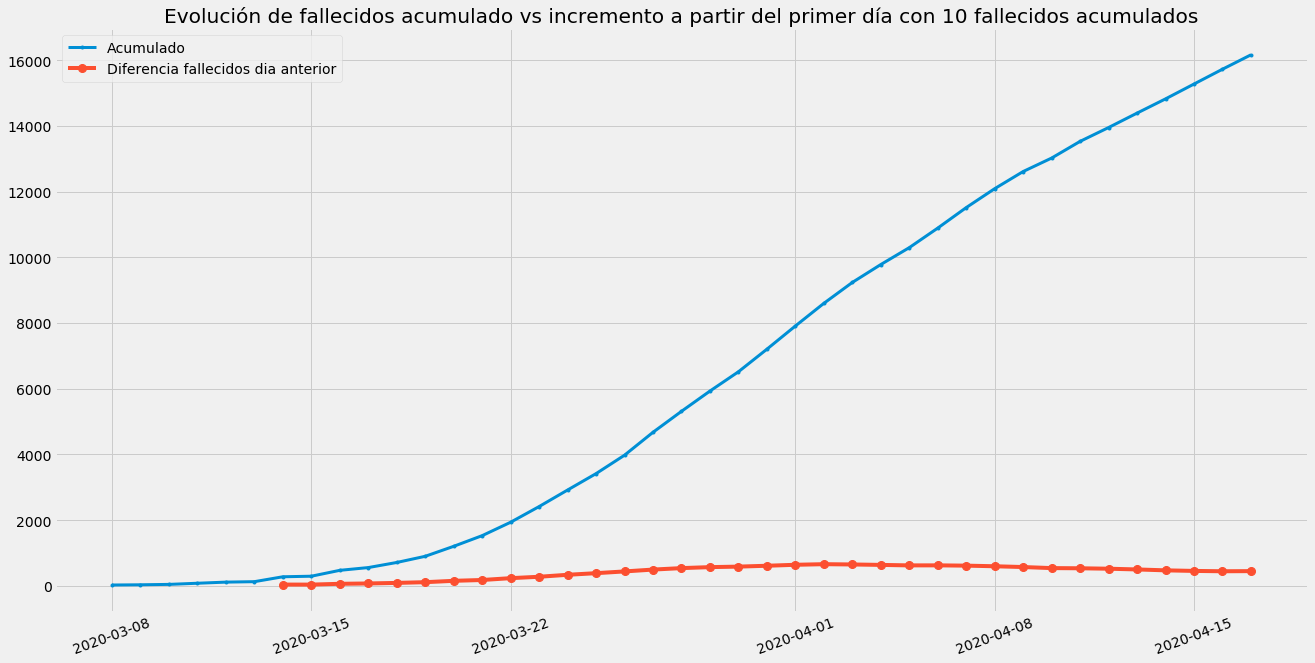

In [17]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='.', linestyle='-', linewidth=3, label='Acumulado')
ax.plot(data_sem.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=8, linestyle='-', label='Diferencia fallecidos dia anterior')
plt.xticks(rotation=20)
plt.title("Evolución de fallecidos acumulado vs incremento a partir del primer día con 10 fallecidos acumulados")
ax.legend();

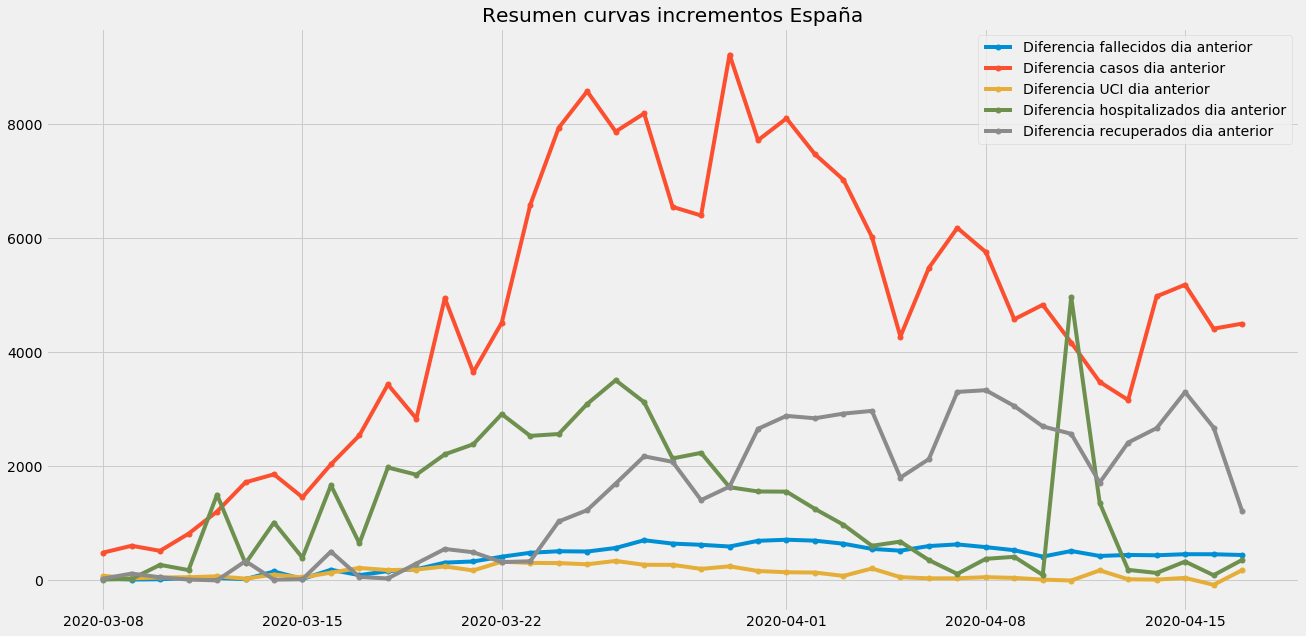

In [18]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
plt.title("Resumen curvas incrementos España");
ax.legend();

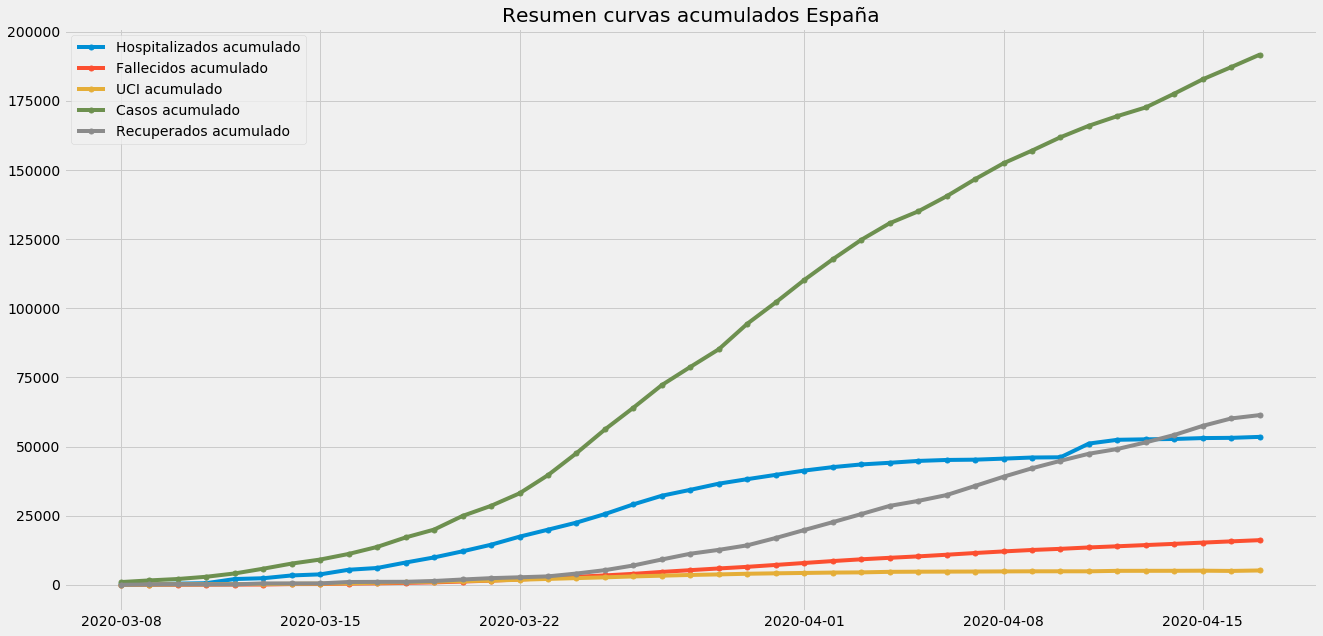

In [19]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(data_es.loc[start:end, 'Hospitalizados'],
marker='o', markersize=5, linestyle='-', label='Hospitalizados acumulado')
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='o', markersize=5, linestyle='-', label='Fallecidos acumulado')
ax.plot(data_es.loc[start:end, 'UCI'],
marker='o', markersize=5, linestyle='-', label='UCI acumulado')
ax.plot(data_es.loc[start:end, 'Casos'],
marker='o', markersize=5, linestyle='-', label='Casos acumulado')
ax.plot(data_es.loc[start:end, 'Recuperados'],
marker='o', markersize=5, linestyle='-', label='Recuperados acumulado')
plt.title("Resumen curvas acumulados España");
ax.legend();

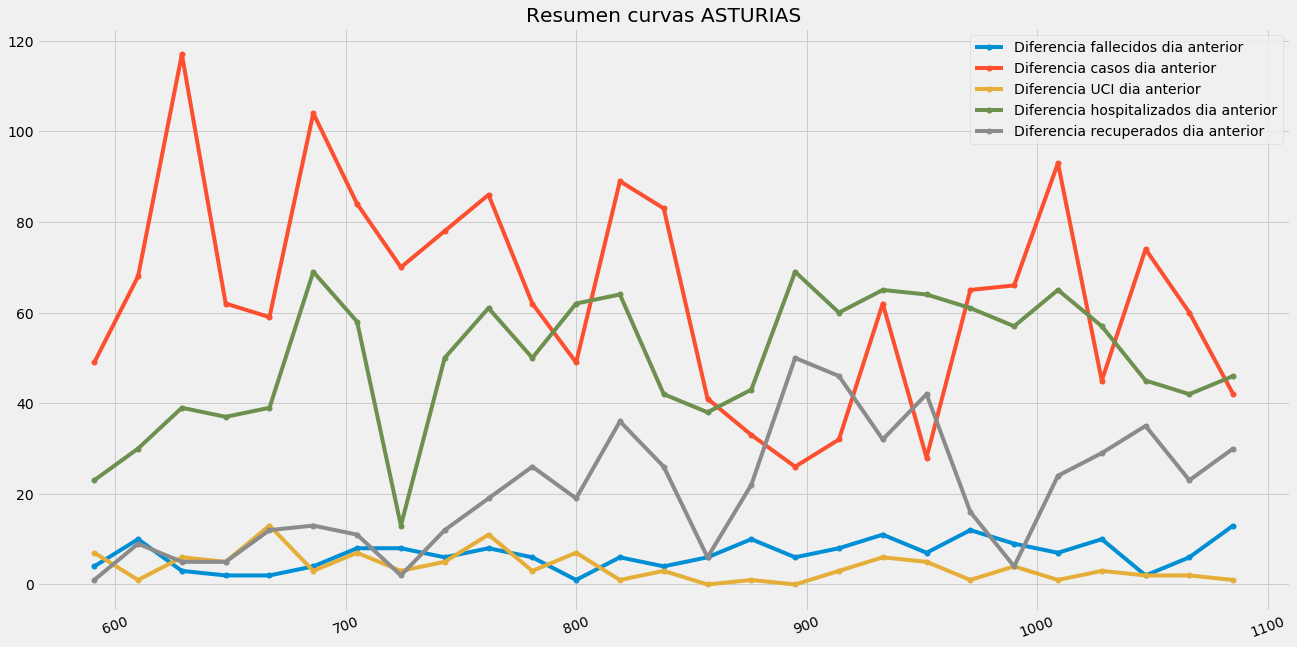

In [20]:
#Introducir código ISO de la comunidad a analizar (ejemplo Asturias) 
data = data[data["Fallecidos"] > 10]

start, end = data[data["CCAA Codigo ISO"] == "AS"].index.min(), data[data["CCAA Codigo ISO"] == "AS"].index.max()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
ax.legend()
plt.xticks(rotation=20)
plt.title("Resumen curvas ASTURIAS");

Casos positivos: 33446.0
Casos negativos: 50001.05
Numero de tests totales: 83447.05


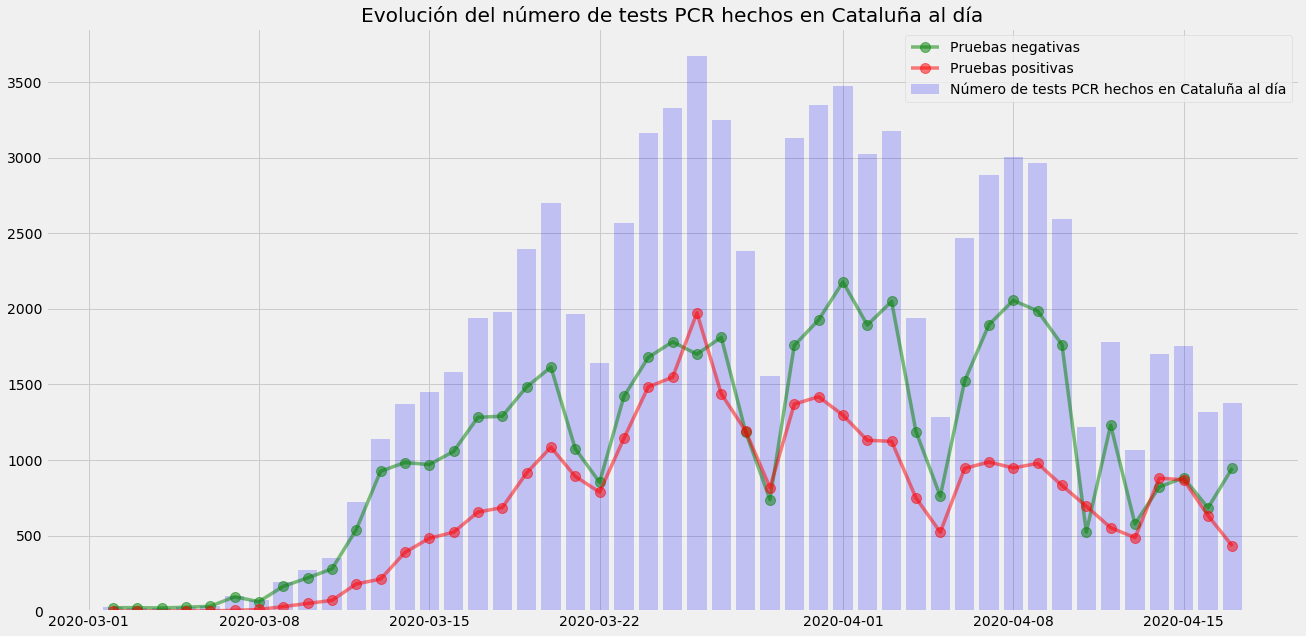

In [21]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['ResultatCovidDescripcio'] == "Negatiu"]["NumCasos"]
         ,alpha=0.5,color='green',
         label='Pruebas negativas',marker='o', markersize=10,linewidth=3.5)

ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['ResultatCovidDescripcio'] == "Positiu"]["NumCasos"]
         ,alpha=0.5,color='red',
         label='Pruebas positivas',marker='o', markersize=10,linewidth=3.5)


#Next lines plot the bar chat part of the plot
ax2.bar(data_cat_gropued.index, data_cat_gropued["NumCasos"],width=0.8, alpha=0.2, color='blue',
       label='Número de tests PCR hechos en Cataluña al día')

ax1.grid(b=True) #Turn on grid

print ("Casos positivos:", data_cat_gropued_resultado[data_cat_gropued_resultado['ResultatCovidDescripcio'] == "Positiu"]["NumCasos"].sum())
print ("Casos negativos:", data_cat_gropued_resultado[data_cat_gropued_resultado['ResultatCovidDescripcio'] == "Negatiu"]["NumCasos"].sum())
print ("Numero de tests totales:", data_cat_gropued_resultado["NumCasos"].sum())

#set up the title and legend
ax1.set_title('Evolución del número de tests PCR hechos en Cataluña al día')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\tests.png');



In [22]:
data_sem_jh = data_sem_jh[data_sem_jh["Fallecidos"] >= 10]
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh = data_sem_jh.set_index('Fecha')
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh["Time_delta"] = 0
data_sem_jh["Time_delta"] = pd.to_timedelta(data_sem_jh["Time_delta"])


In [23]:
for geo in data_sem_jh["Country/Region"].unique():
    data_sem_out = data_sem_jh[data_sem_jh["Country/Region"] == geo]
    data_sem_out["Time_delta"] = data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"] - data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"].min()
    data_sem_jh[data_sem_jh["Country/Region"] == geo] = data_sem_out[data_sem_out["Country/Region"] == geo]

In [24]:
data_sem_jh["Time_delta"] = data_sem_jh["Time_delta"].astype('timedelta64[D]')
data_sem_jh = data_sem_jh.set_index('Time_delta')


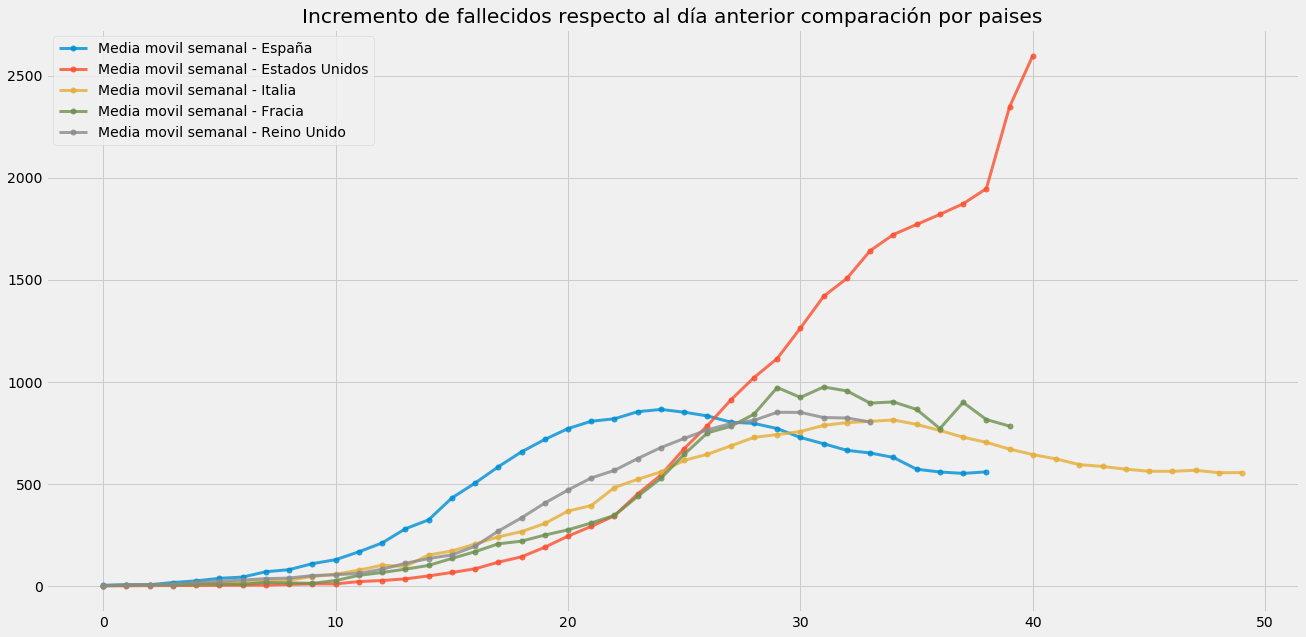

In [25]:
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - España')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Estados Unidos')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Italia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8 ,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Fracia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") 
                    & (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Reino Unido')

plt.title("Incremento de fallecidos respecto al día anterior comparación por paises")
ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\paises.png');

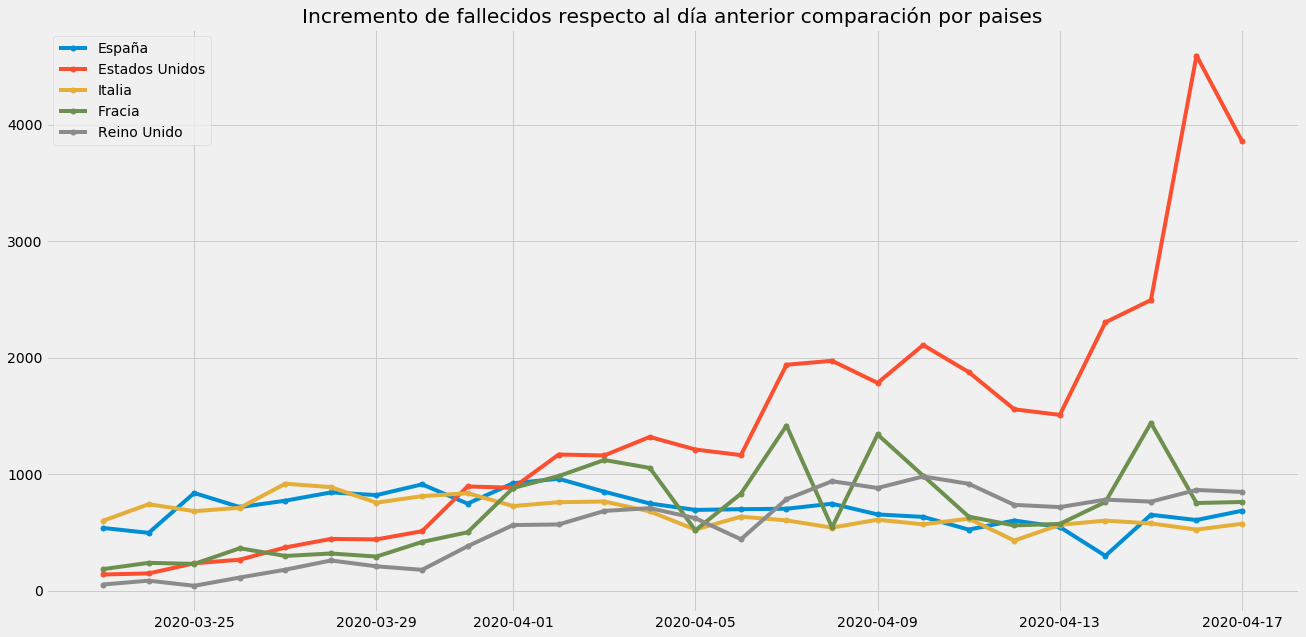

In [26]:
start, end = '2020-03-23 00:00:00', data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_jh[(data_jh["Country/Region"] == "US") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_jh[(data_jh["Country/Region"] == "Italy") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_jh[(data_jh["Country/Region"] == "France") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_jh[(data_jh["Country/Region"] == "United Kingdom") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de fallecidos respecto al día anterior comparación por paises");
ax.legend();

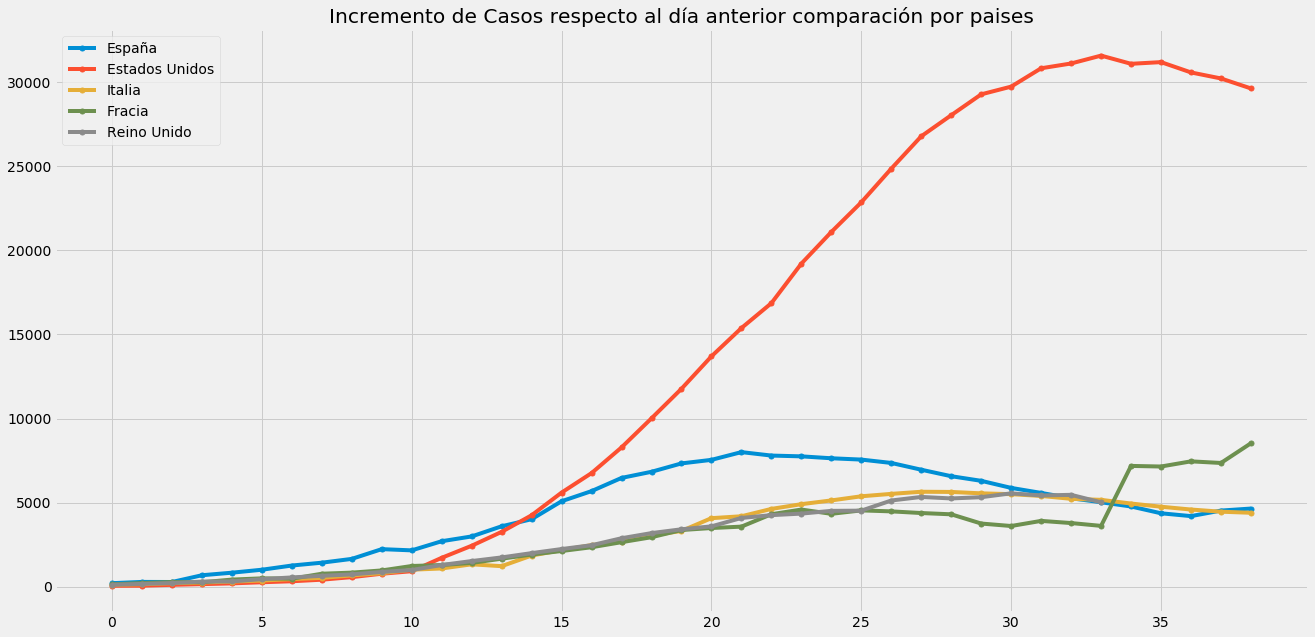

In [27]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de Casos respecto al día anterior comparación por paises");
ax.legend();

In [28]:
data_jh[["Country/Region","Diferencia casos dia anterior"]].sort_values("Diferencia casos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia casos dia anterior
Fecha,,
2020-04-10,US,35098.0
2020-04-04,US,33267.0
2020-04-08,US,32829.0
2020-04-09,US,32385.0
2020-04-17,US,31905.0
2020-04-03,US,31824.0
2020-04-16,US,31451.0
2020-04-02,US,30390.0
2020-04-11,US,29861.0


In [29]:
data_jh[["Country/Region","Diferencia fallecidos dia anterior"]].sort_values("Diferencia fallecidos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia fallecidos dia anterior
Fecha,,
2020-04-16,US,4591.0
2020-04-17,US,3857.0
2020-04-15,US,2494.0
2020-04-14,US,2303.0
2020-04-10,US,2108.0
2020-04-08,US,1973.0
2020-04-07,US,1939.0
2020-04-11,US,1876.0
2020-04-09,US,1783.0


In [30]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

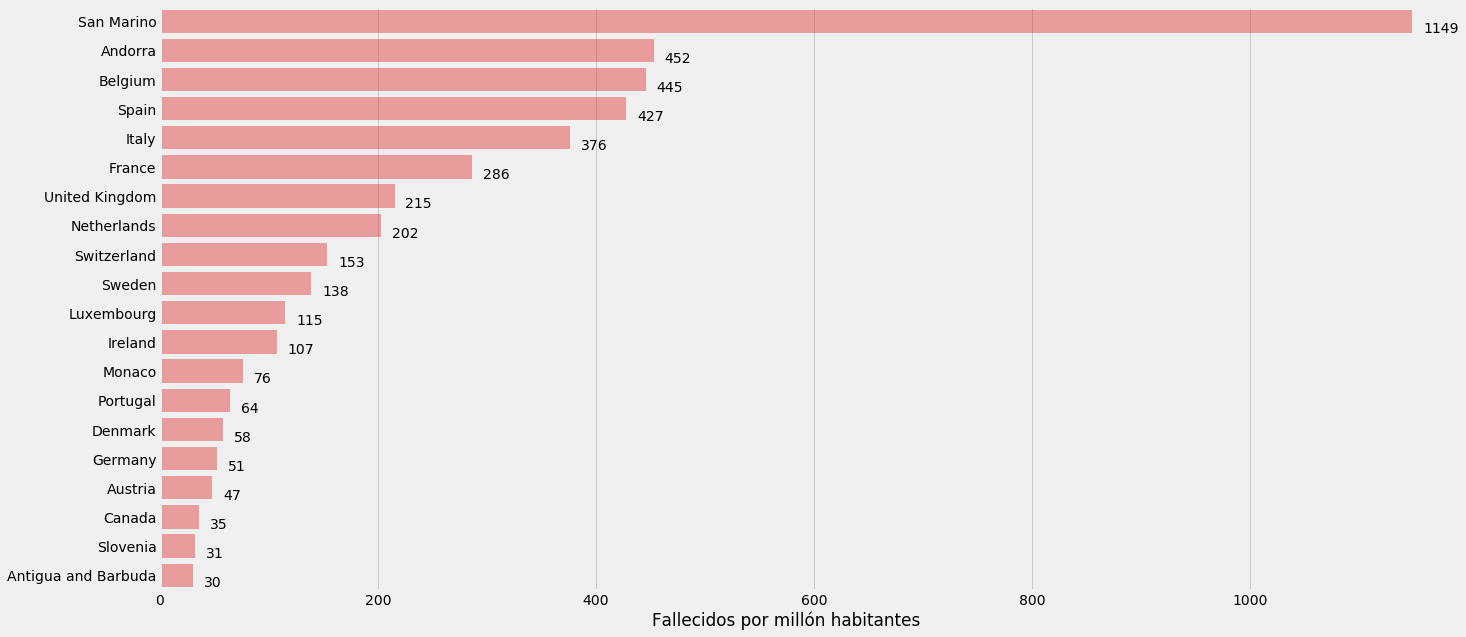

In [31]:

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20,10))

# Load the example car crash dataset
df = data_jh.groupby(["Country/Region"]).max()["Fallecidos por millón habitantes"].sort_values(ascending=False).to_frame().reset_index().head(20)

# Plot the total crashes
sns.barplot(x="Fallecidos por millón habitantes", y="Country/Region", data=df,
            label="Total", color="r", alpha=0.4)



# Add a legend and informative axis label
ax.set(xlim=(0, df["Fallecidos por millón habitantes"].max()), ylabel="",
       xlabel="Fallecidos por millón habitantes")
show_values_on_bars(ax, "h", 10);


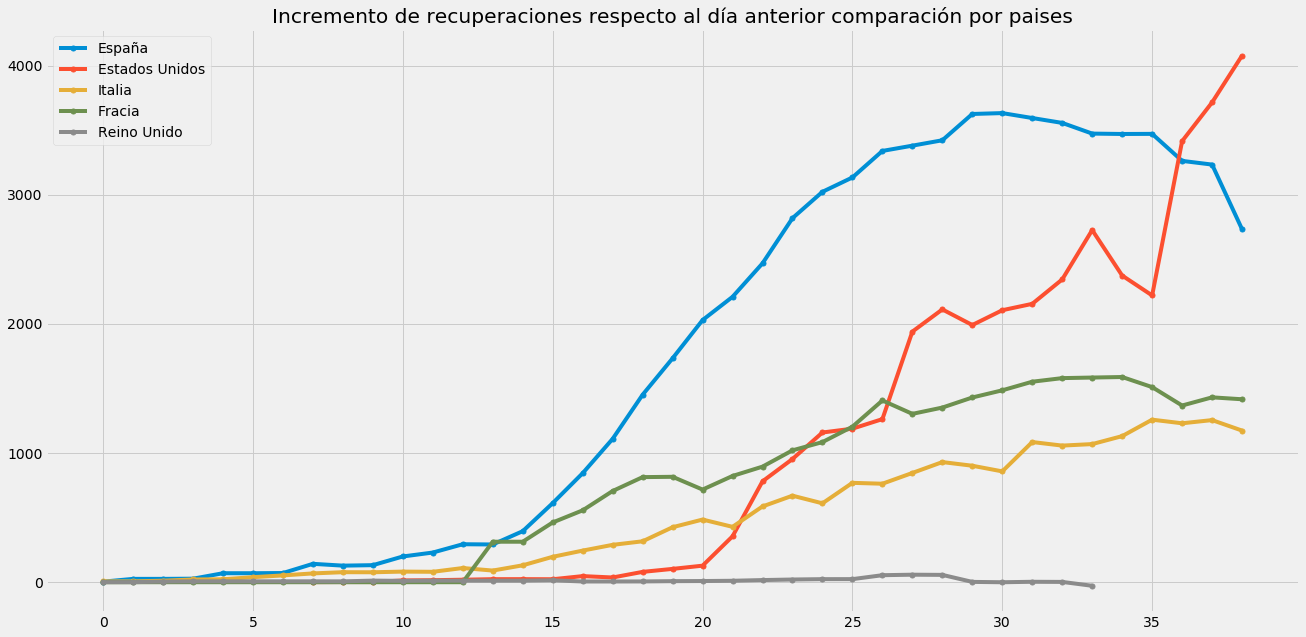

In [32]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de recuperaciones respecto al día anterior comparación por paises");
ax.legend();

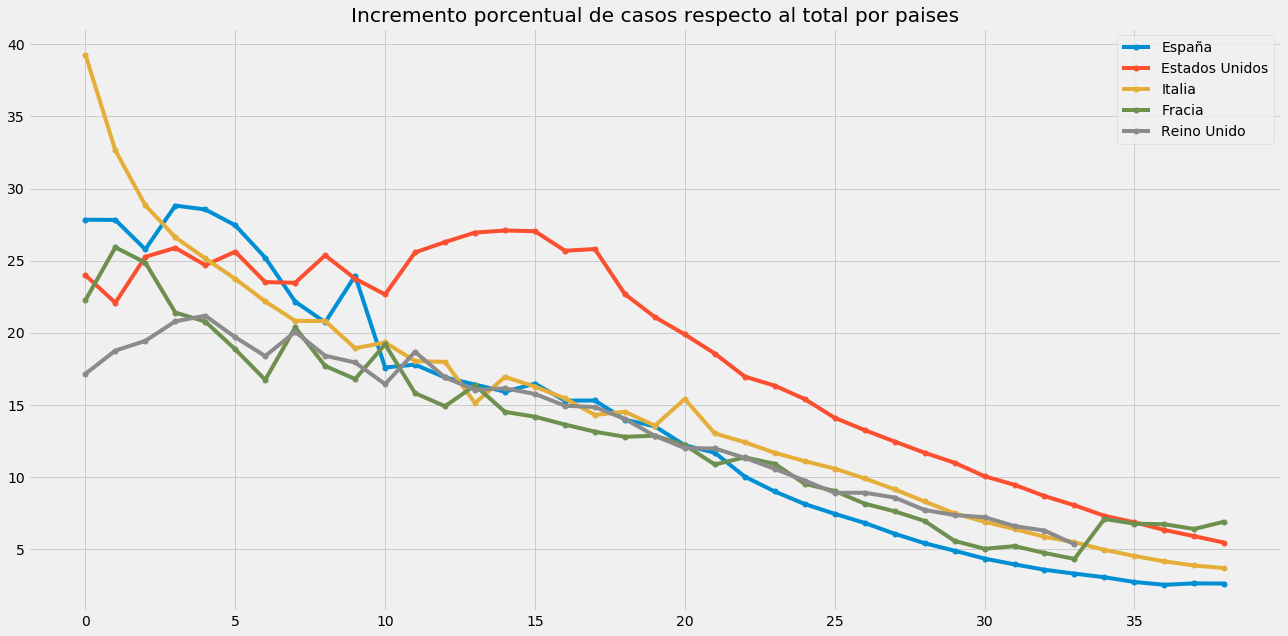

In [33]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de casos respecto al total por paises");
ax.legend();

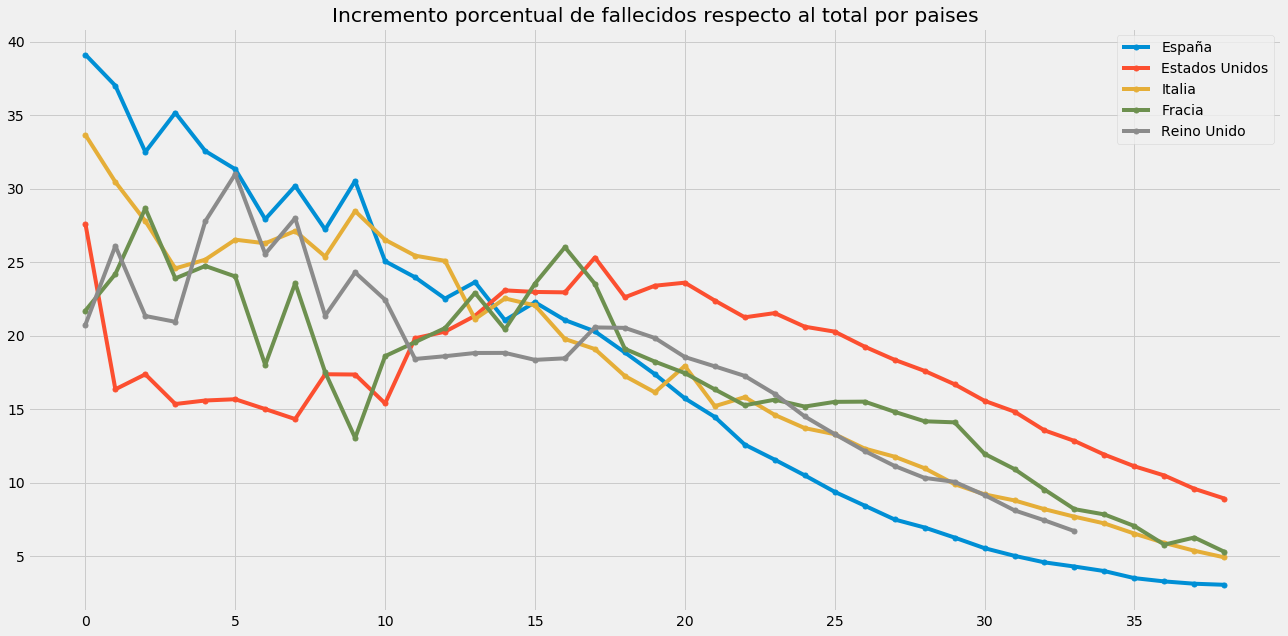

In [34]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de fallecidos respecto al total por paises");
ax.legend();

In [35]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


In [36]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
data_sem.index.freq="D"
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:225.18434012663442
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:168.4895223366882
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:154.80182931086165
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:30.009227137435037
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:167.92489443872245
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:149.11385732910895


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:22.236285360894733


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:18.670888141630833
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:183.1091685560423
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:131.1283421086694
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:114.20457847376787
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3.0199651254261015
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:157.76289860829075
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:133.12816037636463
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:14.489179723416285
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5.66005641731702
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-16.987648745028583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-50.04215092015977
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:62.69711865773388
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-14.515098272443087
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-61.05203527608042


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-42.91479623342801
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-19.06354413796074
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-16.955459701107703
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-24.080692154022238
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-79.75409937170626
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:44.912198444031425
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-25.06726232725835
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-74.5943825534884
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-51.67197107535165
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-25.67900249461998
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-25.55871337329934
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-21.559503166471714
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-58.07054968318043
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:63.50088242871211
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-33.53846148811413
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-62.07149870327298


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-42.34164636762644
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-28.546674004236387


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-36.296169012439755
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-26.063987967518997
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-72.92131916073079


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:49.86330929520363


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-37.55315285842237
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-76.0678895227082
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-72.5145989576359
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-35.698556020347965


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-43.492869701582244
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-26.35992064648365
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-95.72054228403387
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:55.79985861552934


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-36.281145204621765
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-104.21096450739981
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-103.0788659427324


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-34.6560529950227
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-33.299459231693945
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-30.11367233577584
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-119.31902527155091


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:40.98368031451666


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-47.43428021770153
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-109.11903874512994
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-91.7831061070595


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-43.77885363341407
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-48.38380815971601


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [37]:
mod2 = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   41
Model:               SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                   9.258
Date:                                Sat, 18 Apr 2020   AIC                            -14.515
Time:                                        21:28:11   BIC                            -13.099
Sample:                                    03-08-2020   HQIC                           -14.530
                                         - 04-17-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.2482      0.453      0.548      0.583      -0.639       1.135
sig

In [38]:
data_sem.index.max()

Timestamp('2020-04-17 00:00:00')

2020-04-18    435.789904
2020-04-19    415.320773
2020-04-20    384.624567
2020-04-21    366.289767
2020-04-22    338.140653
2020-04-23    335.323713
2020-04-24    324.751055
2020-04-25    308.720060
2020-04-26    287.884838
2020-04-27    279.972850
Freq: D, dtype: float64


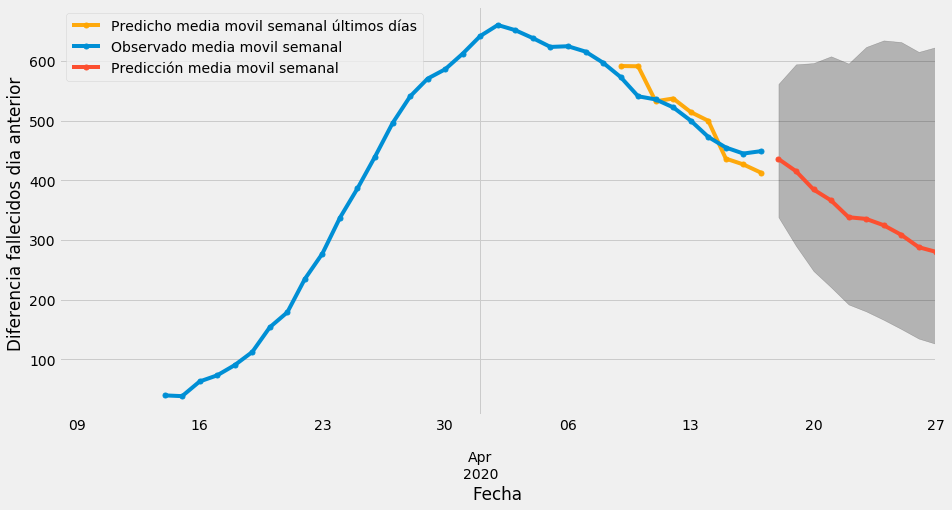

In [39]:
pred_uc_prev = results2.get_prediction(start=pd.to_datetime('2020-04-09 00:00:00'))

pred_uc_prev = math.e**pred_uc_prev.predicted_mean

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho media movil semanal últimos días',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_sem["Diferencia fallecidos dia anterior"].plot(label='Observado media movil semanal', figsize=(14, 7),marker='o', markersize=5)
pred_uc.plot(ax=ax, label='Predicción media movil semanal',marker='o', markersize=5)
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.legend()
plt.show()


In [40]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:254.958998624083
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1236.110340354654
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:111.30002664799773
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:15.22151125929331
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:114.68897706892915


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1105.1843371179366
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:19.372159320254916
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:10.825244654831755
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:209.83895220395434


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1154.3838260517537
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:90.86662434790664
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:0.5828879371367677
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:104.25821138653886


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:914.636820959049
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:8.130448854543278
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-4.223442419786551
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:86.01712427601248


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1019.8459913179897
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:70.78995768470956
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-2.094787047801109
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-35.693138868029635
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:997.1187361473295
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-3.4407202407865807
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-2.0833532844033176
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:71.84076898520985


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:960.9527754052535
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:58.43645664923627
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-1.4784633704983339
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-33.78420779245905


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:985.5660622629285


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-1.6157902015312677
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-1.4472646284572708
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:92.50345207403686


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1100.1231410452597
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:73.81122639594462
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-6.76645798375886
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-33.997883314793484


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:851.6346670255365
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-6.748010110899088
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-10.421384248569254
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:73.88930288168893


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1059.8116212950533
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:54.153918469530055


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-4.925363938530712
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-32.06273710506709


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:820.2322120247658


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-4.688002580331208


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-10.573432962213314
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:61.25352342067691


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:951.1344617923128
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:52.1174536001846
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-0.2865293861074756
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-31.573645882430682


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:976.6153897327788
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-0.27979206527638745
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-0.15879406594086376
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:61.82052766728556


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:940.9836159097008
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:51.26731276195562
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-1.1320479112045323
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-36.859799984459876


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:965.5997168368333
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-3.8829347311919413
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:0.5328996187481341


In [41]:
mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   41
Model:                SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                   5.941
Date:                                Sat, 18 Apr 2020   AIC                             -3.883
Time:                                        21:28:29   BIC                             -1.051
Sample:                                    03-08-2020   HQIC                            -3.913
                                         - 04-17-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7808      0.094      8.265      0.000       0.596       0.966
ma.

Fecha
2020-04-08    704.534949
2020-04-09    523.603827
2020-04-10    487.289711
2020-04-11    392.689158
2020-04-12    575.334358
2020-04-13    441.906263
2020-04-14    435.287486
2020-04-15    405.058876
2020-04-16    385.677417
2020-04-17    413.108933
Freq: D, dtype: float64
2020-04-18    489.609302
2020-04-19    500.752547
2020-04-20    454.535732
2020-04-21    405.520452
2020-04-22    315.365697
2020-04-23    385.830604
2020-04-24    318.623032
2020-04-25    330.247603
2020-04-26    324.211608
2020-04-27    336.747739
Freq: D, dtype: float64


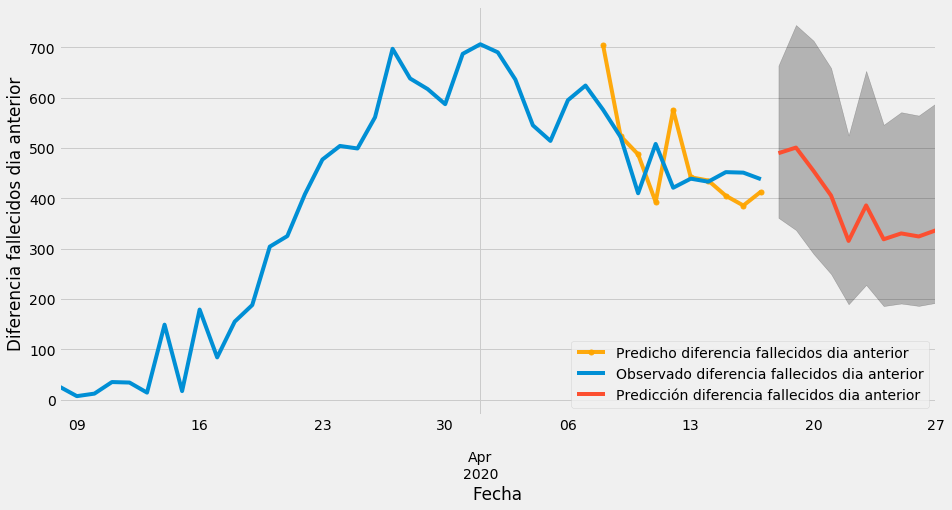

In [42]:
pred_uc_prev = results.get_prediction(start=pd.to_datetime('2020-04-08 00:00:00'))
pred_uc_prev = math.e**pred_uc_prev.predicted_mean

print(pred_uc_prev)

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho diferencia fallecidos dia anterior',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)


pred_uc = results.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_es["Diferencia fallecidos dia anterior"].plot(label='Observado diferencia fallecidos dia anterior', figsize=(14, 7))
pred_uc.plot(ax=ax, label='Predicción diferencia fallecidos dia anterior')
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción.png')

plt.legend()
plt.show()

In [43]:
from statsmodels.formula.api import ols
data_mad= data_mad[data_mad["fecha_informe"] == data_mad["fecha_informe"].max()]
results = ols('tasa_incidencia_acumulada_total ~ data_mad["Renta Categorical"] ', data=data_mad).fit()
table = sm.stats.anova_lm(results)
table

,df,sum_sq,mean_sq,F,PR(>F)
"data_mad[""Renta Categorical""]",4.0,6.991175e+05,174779.375125,2.5874,0.04208
Residual,90.0,6.079518e+06,67550.195818,NaN,NaN


In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     tasa_incidencia_acumulada_total   R-squared:                       0.103
Model:                                         OLS   Adj. R-squared:                  0.063
Method:                              Least Squares   F-statistic:                     2.587
Date:                             Sat, 18 Apr 2020   Prob (F-statistic):             0.0421
Time:                                     21:28:31   Log-Likelihood:                -660.46
No. Observations:                               95   AIC:                             1331.
Df Residuals:                                   90   BIC:                             1344.
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            734.9100     63.036     11.659      0.000     609.678     860.142
data_mad["Renta Categorical"][T.Renta Baja]           89.3225     97.993      0.912      0.364    -105.359     284.004
data_mad["Renta Categorical"][T.Renta Media-Alta]   -108.2214     93.801     -1.154      0.252    -294.573      78.130
data_mad["Renta Categorical"][T.Renta Media-Baja]    -76.0984     81.704     -0.931      0.354    -238.418      86.221
data_mad["Renta Categorical"][T.Renta Media-Media]  -173.8944     80.470     -2.161      0.033    -333.762     -14.027
==============================================================================
Omnibus:                        4.435   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                4.387
Skew:                           0.521   Prob(JB):                        0.112
Kurtosis:                       2.845   Cond. No.                         6.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""